In [1]:
import numpy as np
import cv2 as cv
import math,os,random
from imageio import imread, imwrite
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Image Mosaicing

In [2]:
def SIFT_(img):
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    
   
    return kp,des

In [3]:
def good_matches(des1,des2,ratio=0.5):
        
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append(m)
       
    return good

In [4]:
def solve_homography(src,dest):
        
    M = []
    for i in range(len(src)):
        x,y=src[i]
        x1,y1=dest[i]
        M.append([-x,-y,-1,0,0,0,x1*x,x1*y,x1])
        M.append([0,0,0,-x,-y,-1,y1*x,y1*y,y1])
    M = np.array(M)
    
    try:
        u, s, v = np.linalg.svd(M)
        P = v[8].reshape((3, 3))
        P = P / P[2, 2]
        return P
    except:
        return None

def get_error(src,dest,P):
    src = np.array(src)
    size=src.shape[0]
    homogeneous_src=np.concatenate((src.T, np.ones((1,size))),axis=0)
    
    dest_coord = np.dot(P,homogeneous_src) 
    dest_coord=(dest_coord/dest_coord[2:]) 
    dest_coord=(dest_coord[0:2]).T
    
    # Mean squared error
    error = np.mean(np.sqrt(np.sum((dest_coord-dest)**2,1)))
    return error  

def RANSAC(src,dest,num_pts=6,num_iter=50):
    min_error=10
    for i in range(num_iter):
        src_pts = []
        dest_pts = []
        lst=list(range(src.shape[0]))
        if(num_pts > len(lst)):
            print(num_pts,len(lst))
            print(src.shape[0])
        while(len(src_pts)<num_pts):
            ind = random.randint(0,len(lst)-1)
            j=lst.pop(ind)
            src_pts.append(src[j,:])
            dest_pts.append(dest[j,:])
        h = solve_homography(src_pts,dest_pts)
        if h is None:
            continue
        e = get_error(src_pts,dest_pts,h)
        if e<min_error:
            res=h
            min_error=e
    return res


In [5]:
def find_homography(img1,img2,Ransac = False):
    
    kp1, des1 = SIFT_(img1)
    kp2, des2 = SIFT_(img2)
   
    good = good_matches(des1,des2)
    
    src = []
    dst = []
    for m in good:
        src.append(kp1[m.queryIdx].pt)
        dst.append(kp2[m.trainIdx].pt)
    src = np.array(src)
    dst = np.array(dst)
    
    if Ransac:
        H = RANSAC(src, dst)
    else:
        H = solve_homography(src,dst)
    
    return H
    

In [12]:
def crop_image(img,tol=80):
    
    # convert img into grayscale
    gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    mask = gray>tol # tol  is tolerance
    img = img[np.ix_(mask.any(1),mask.any(0))]
    return img

In [7]:
def stitch(img1,img2):
    
    H = find_homography(img1,img2,Ransac=True)
    
#     size = (2 * img1.shape[1], 2 * max(img1.shape[0], img2.shape[0]))
    
    dst = cv.warpPerspective(img1, H, (2 * img1.shape[1], 2 * max(img1.shape[0], img2.shape[0])))
    dst[0:img2.shape[0], 0:img2.shape[1], :] = img2
    dst = crop_image(dst)
    
    fig = plt.figure(figsize=(10,10),dpi=80)
#     cv.imwrite('../output_images/stitch'+str(ind)+'.jpg',dst)
    plt.imshow(dst)
    plt.show()
    
    return dst
    
    

In [8]:
def scale(im,scale_percent=0.3):
    width = int(im.shape[1] * scale_percent )
    height = int(im.shape[0] * scale_percent )
    print(width,height)
    im = cv.resize(im, (width, height), interpolation = cv.INTER_AREA)
    return im

In [9]:
def get_images(name,n,ext):
    images=[]
    for i in range(n,0,-1):
        img='../images/Image Mosaicing/'+name+str(i)+ext
        print(img)
        img = cv.cvtColor(cv.imread(img), cv.COLOR_BGR2RGB)
        img = scale(img,0.7) 
        images.append(img)
    return images

In [10]:
def stitch_pano(images):
    global ind
    temp = images[0]
    
    for i in range(1,len(images)):
        ind = i
        temp = stitch(temp,images[i])
    return temp

In [14]:
images = get_images('1_',4,'.jpg')

../images/Image Mosaicing/1_4.jpg
2867 1353
../images/Image Mosaicing/1_3.jpg
3225 1523
../images/Image Mosaicing/1_2.jpg
3225 1523
../images/Image Mosaicing/1_1.jpg
3225 1523


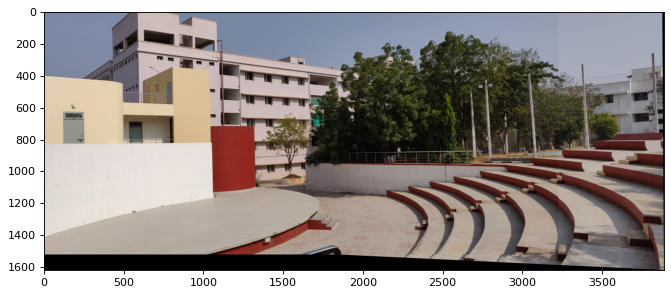

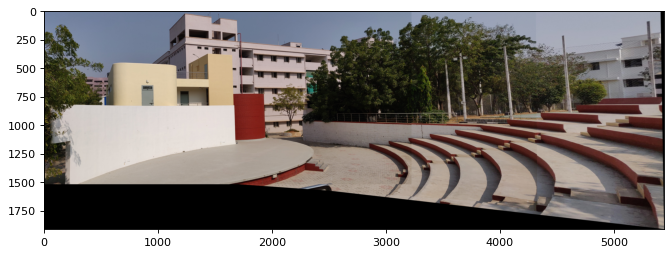

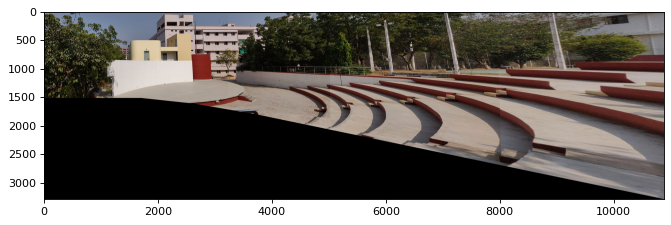

In [15]:
# img='../output_images/stitch0.jpg'
final=stitch_pano(images)

In [36]:
images = get_images('2_',6,'.png')

../images/Image Mosaicing/2_6.png
417 213
../images/Image Mosaicing/2_5.png
491 270
../images/Image Mosaicing/2_4.png
222 268
../images/Image Mosaicing/2_3.png
380 218
../images/Image Mosaicing/2_2.png
520 222
../images/Image Mosaicing/2_1.png
507 221


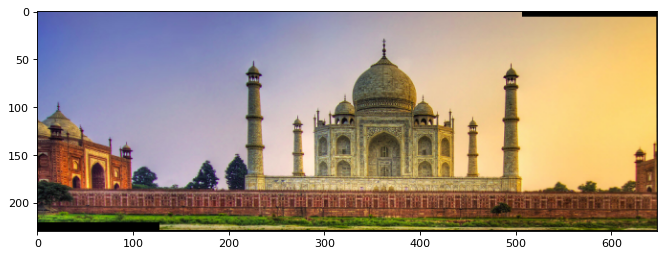

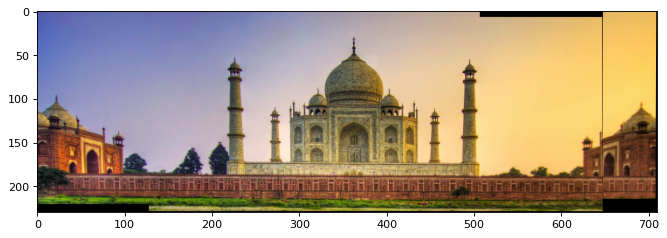

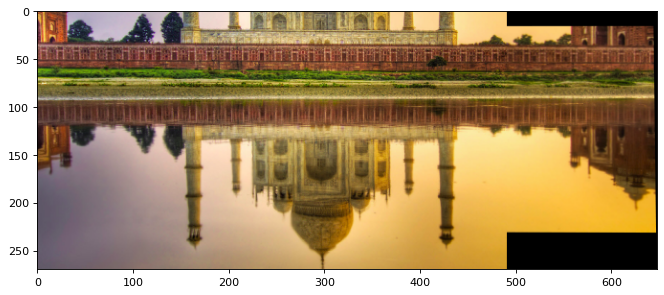

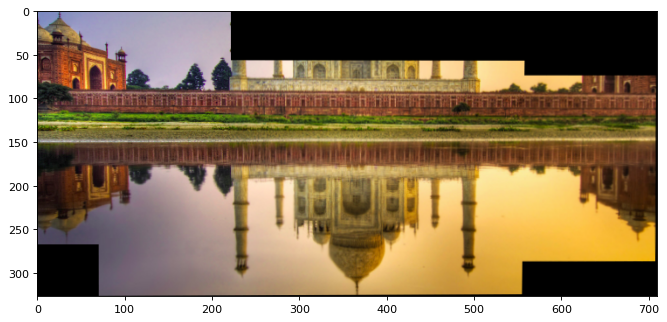

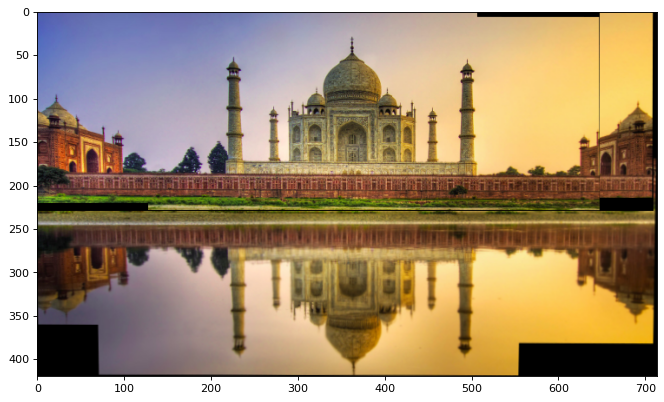

In [37]:
top = stitch(images[4],images[5])
top = stitch(images[3],top)

bottom = stitch(images[0],images[1])
bottom = stitch(bottom,images[2])

final = stitch(bottom,top)

../images/Image Mosaicing/3_2.png
700 525
../images/Image Mosaicing/3_1.png
700 525


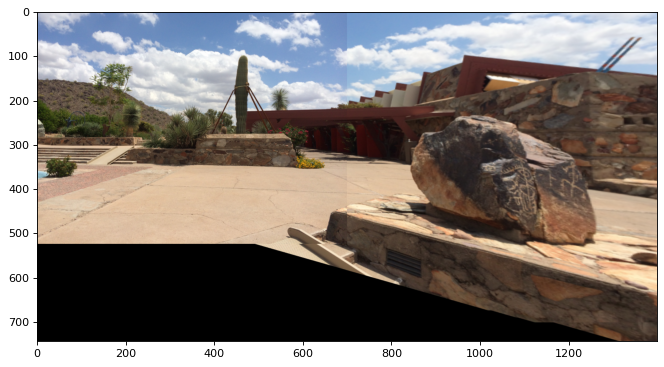

In [16]:
images = get_images('3_',2,'.png')

final = stitch(images[0],images[1])

../images/Image Mosaicing/5_4.jpg
3225 1523
../images/Image Mosaicing/5_3.jpg
3225 1523
../images/Image Mosaicing/5_2.jpg
3225 1523
../images/Image Mosaicing/5_1.jpg
3225 1523


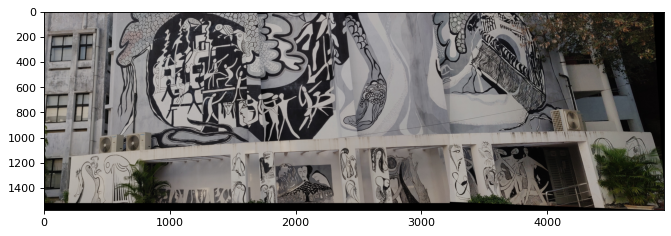

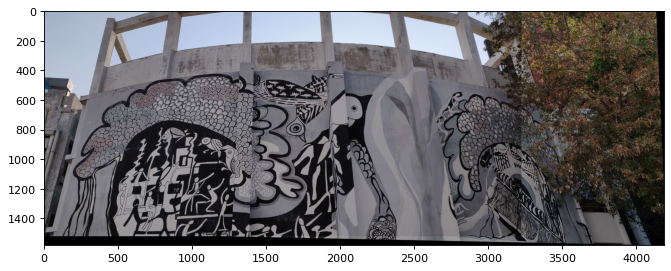

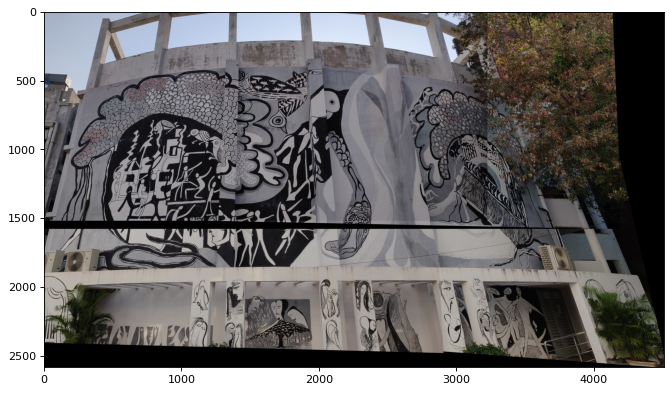

In [17]:
images = get_images('5_',4,'.jpg')

bottom = stitch(images[1],images[0])
top = stitch(images[2],images[3])

final = stitch(bottom,top)

# 2. Stereo Correspondences

In [19]:
import numpy as np
import cv2 as cv
import math,os,random
from imageio import imread, imwrite
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [20]:
def display(imgs,x=8,y=8):
    for img in imgs:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        fig = plt.figure(figsize=(x,y),dpi=80)
        plt.imshow(img)
        plt.show()

In [21]:
def get_imgs(img1,img2):
    

    left = cv.cvtColor(cv.imread("../images/Stereo Correspondence/"+img1), cv.COLOR_BGR2RGB)
    right = cv.cvtColor(cv.imread("../images/Stereo Correspondence/"+img2), cv.COLOR_BGR2RGB)
    height = min(left.shape[0] ,right.shape[0])
    im_list = [cv.resize(im, (int(im.shape[1] * height / im.shape[0]), height))for im in [left,right]]
    img = cv.hconcat(im_list)
    return im_list[0],im_list[1],img

# left = cv.cvtColor(cv.imread("../images/Stereo Correspondence/3_1.jpg"), cv.COLOR_BGR2RGB)
# right = cv.cvtColor(cv.imread("../images/Stereo Correspondence/3_2.jpg"), cv.COLOR_BGR2RGB)

In [22]:
def correlation(img1,img2,lim=0.6,window=50,step=50):
    dic = {}
    best_matches = []
    row1,col1,_ = img1.shape
    row2,col2,_ = img2.shape
    for r1 in range(0,row1-window,step):
        for c1 in range(0,col1-window,step):
            patch1 = img1[r1:r1+window, c1:c1+window,:].flatten()
            thresh = lim
            match = []
            for r2 in range(0,row2-window,step):
                for c2 in range(0,col2-window,step):
                    patch2 = img2[r2:r2+window,c2:c2+window,:].flatten()
                    try:
                        cor = np.corrcoef(patch1,patch2)[1][0]
                    except:
                        continue
                    if cor > thresh:
                        thresh = cor
                        match = [r1,c1,r2,c2,thresh]
            if len(match)>0:
                x2,y2 = (match[2],match[3])
                if (x2,y2) in dic:
                    dist = dic[(x2,y2)][0]
                    if match[-1] > dist:
                        x1,y1 = dic[(x2,y2)][1:]
                        best_matches.remove([x1,y1,x2,y2,dist])
                        best_matches.append(match)
                        dic[(x2,y2)]=(match[-1],match[0],match[1])
#                 if (x2,y2) not in dic:
                else:
                    dic[(x2,y2)]=(match[-1],match[0],match[1])
                    best_matches.append(match)
    return best_matches

In [23]:
def draw_matches(img,matches,step=25):
    h,w,_ = img.shape
    print(len(matches))
    for match in matches:
        pt1 = (match[0]+step,match[1]+step)
        pt2 = (match[2]+step+w//2,match[3]+step)
        line_img = cv.line(img,pt1,pt2,(0,255,0),3)
    display([line_img],20,10)


In [24]:
left,right,img = get_imgs('1_1.jpg','1_2.jpg')

4


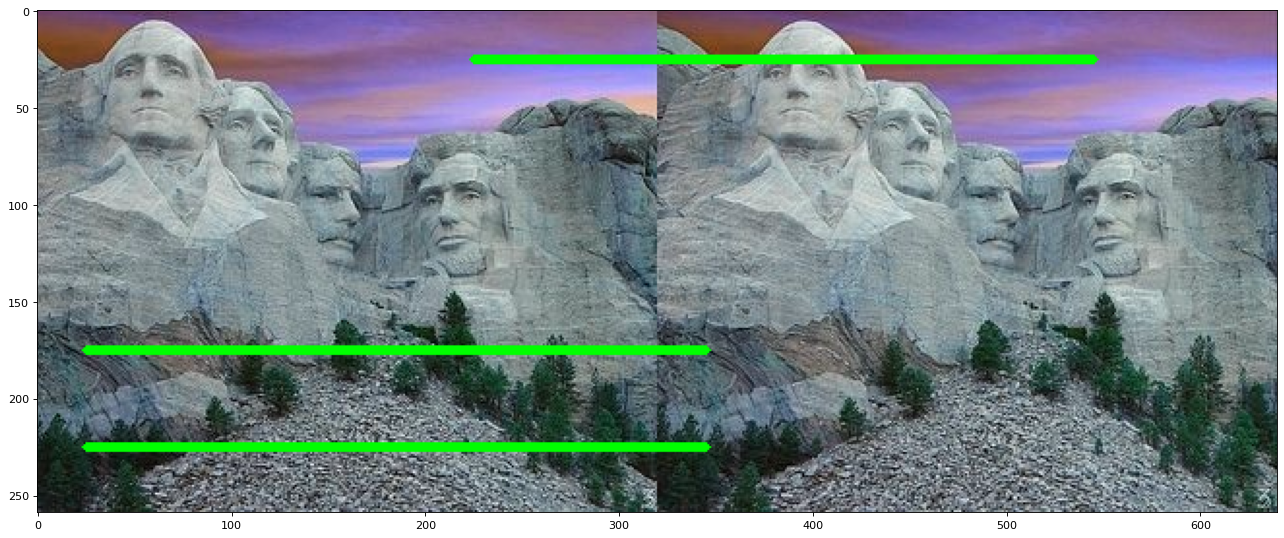

In [25]:
matches = correlation(left,right,lim=0.6)
draw_matches(img,matches)

15


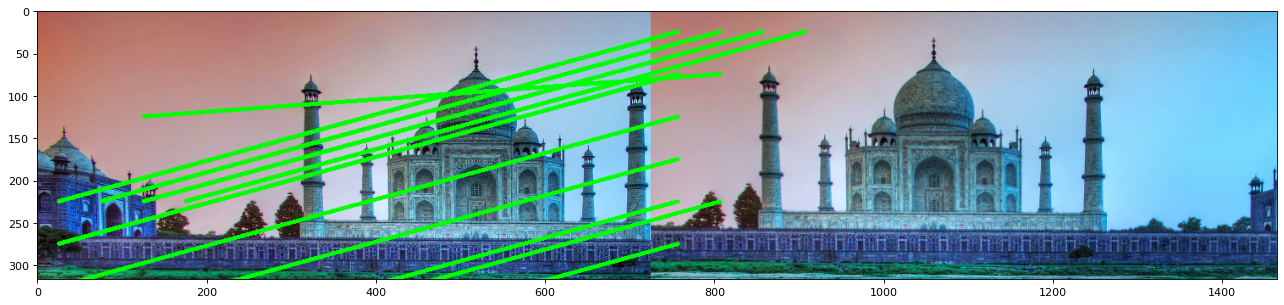

In [48]:
left,right,img = get_imgs('2_1.png','2_2.png')
matches = correlation(left,right,lim=0.95,window=60)
draw_matches(img,matches)

15


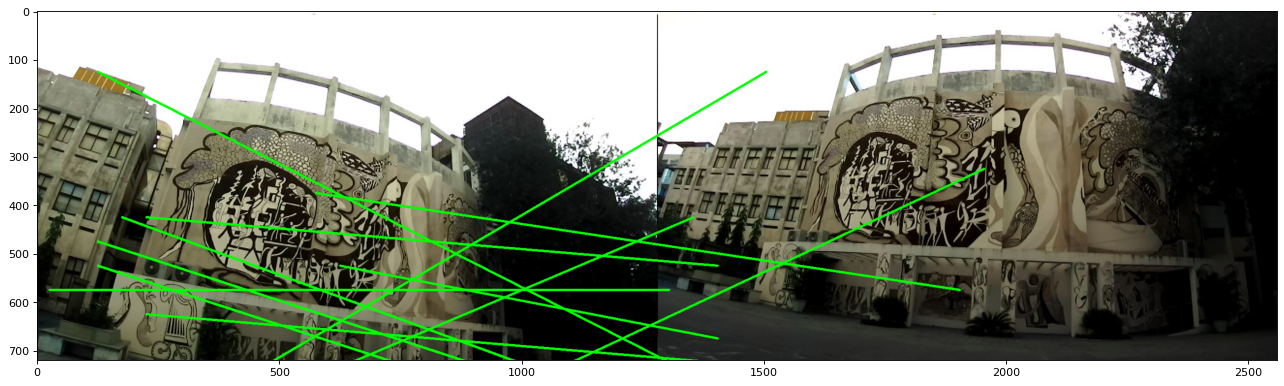

In [51]:
left,right,img = get_imgs('3_1.jpg','3_2.jpg')
matches = correlation(left,right,lim=0.75)
draw_matches(img,matches)

In [52]:
def SIFT_1(img):
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    sift = cv.ORB_create()
    kp, des = sift.detectAndCompute(gray,None)
   
    return kp,des

In [53]:
def good_matches_1(des1,des2,ratio=0.5):
        
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append(m)
       
    return good

### Compute Fundamental matrix

In [54]:
def error1(pts1,pts2,P):
    pts1 = np.array(pts1)
    size=pts1.shape[0]
    homogeneous_pts1=np.concatenate((pts1.T, np.ones((1,size))),axis=0)
    temp = np.dot(P,homogeneous_pts1) 
    
    homogeneous_pts2=(np.concatenate((pts2.T, np.ones((1,size))),axis=0)).T
    temp = np.dot(homogeneous_pts2,temp)
    error = np.sum(temp)
    return (error)

def RANSAC_func(src,dest,num_pts=8,num_iter=50):
    min_error=10
    for i in range(num_iter):
        src_pts = []
        dest_pts = []
        lst=list(range(src.shape[0]))
        if(num_pts > len(lst)):
            print(num_pts,len(lst))
            print(src.shape[0])
        while(len(src_pts)<num_pts):
            ind = random.randint(0,len(lst)-1)
            j=lst.pop(ind)
            src_pts.append(src[j,:])
            dest_pts.append(dest[j,:])
        src_pts = np.int32(src_pts)
        dest_pts = np.int32(dest_pts)
        h = solve_fundamental(src_pts,dest_pts)
        if h is None:
            continue
        e = error1(src_pts,dest_pts,h)
        if e<min_error:
            res=[h,src_pts,dest_pts]
            min_error=e
    return res

def solve_fundamental(pts1,pts2):
    M = []
    for i in range(pts1.shape[0]):
        u,v = pts2[i]
        u1,v1 = pts1[i]
        M.append([u*u1,u*v1,u,v*u1,v*v1,v,u1,v1,1])
    
    M = np.array(M)
    
    try:
        _,_, v = np.linalg.svd(M)
        F = v[8].reshape((3, 3))
        F = F / F[2, 2]
        return F
    except:
        return None

def find_fundamental(img1,img2,threshold=0.5):    
    kp1, des1 = SIFT_1(img1)
    kp2, des2 = SIFT_1(img2)
   
    good = good_matches_1(des1,des2,threshold)
    
    pts1 = []
    pts2 = []
    for m in good:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    F,pts1,pts2 = RANSAC_func(pts1,pts2)
#     F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

    return F,pts1,pts2

### Draw epipolar lines

In [55]:
def compute_lines(pts,F):
    pts=np.concatenate((pts.T, np.ones((1,pts.shape[0]))),axis=0)
    lines = np.dot(F,pts)
    return lines.T  

def drawlines(img1,img2,lines,pts1,pts2):

    _,c,_ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,3)
        img1 = cv.circle(img1,tuple(pt1),10,color,-1)
        img2 = cv.circle(img2,tuple(pt2),10,color,-1)
    return img1,img2

def lines(img1,img2,pts1,pts2,F):
    lines2 = compute_lines(pts1,F)
    lines2 = lines2.reshape(-1,3)
    img1,img2 = drawlines(img2,img1,lines2,pts2,pts1)
    return lines2,img1,img2

### Rectification

In [56]:
def rectify(img1,img2,pts1,pts2,F,size):
    
    H1 = RANSAC(pts1, pts2)
    H2 = RANSAC(pts2, pts1)
    
    #_,H1,H2=cv.stereoRectifyUncalibrated(pts1, pts2, F, size)
    
    img1_ = cv.warpPerspective(img1, H1, size)
    img2_ = cv.warpPerspective(img2, H2, size)
    
    return img1_,img2_

In [58]:
def display_plots(img1,img2):
    f = plt.figure(figsize=(10,4))
    plt.subplot(121),plt.imshow(img1)
    plt.subplot(122),plt.imshow(img2)
    plt.show()

In [59]:
img1_1,img2_1,img_1 = get_imgs('1_1.jpg','1_2.jpg')
F_1,pts1_1,pts2_1 = find_fundamental(img1_1,img2_1)

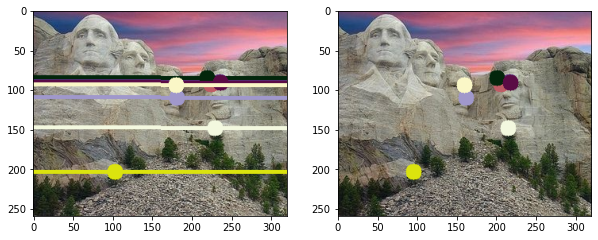

In [60]:
# F is the fundamental matrix corresponding to an ordered pair of images (img1,img2)
lines1_2,img3,img4 = lines(img1_1,img2_1,pts1_1,pts2_1,F_1)

display_plots(img3,img4)

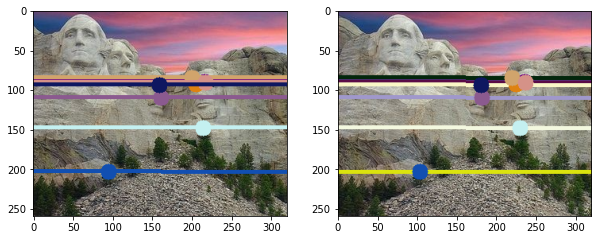

In [61]:
# F.T is the fundamental matrix corresponding to an ordered pair of images (img2,img1)
lines1_1,img5,img6 = lines(img2_1,img1_1,pts2_1,pts1_1,F_1.T)

display_plots(img5,img6)

In [62]:
img1_1,img2_1,img_1 = get_imgs('1_1.jpg','1_2.jpg')

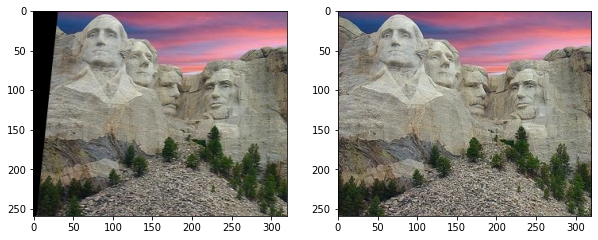

In [63]:
size = (img1_1.shape[1],img1_1.shape[0])
rectified_img1,rectified_img2 = rectify(img1_1,img2_1,pts1_1,pts2_1,F_1,size)

display_plots(rectified_img1,rectified_img2)

In [75]:
img1_2,img2_2,img_2 = get_imgs('2_1.png','2_2.png')
F_2,pts1_2,pts2_2 = find_fundamental(img1_2,img2_2)

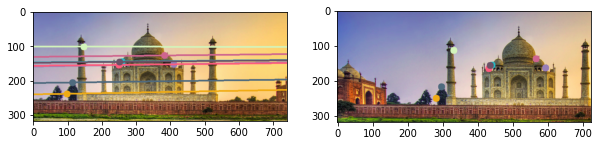

In [76]:
# F is the fundamental matrix corresponding to an ordered pair of images (img1,img2)
lines2_2,img3,img4 = lines(img1_2,img2_2,pts1_2,pts2_2,F_2)

display_plots(img3,img4)

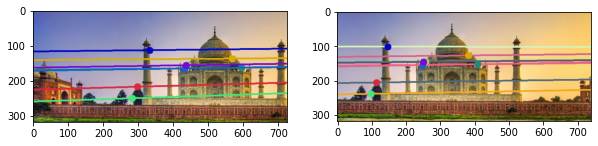

In [77]:
# F.T is the fundamental matrix corresponding to an ordered pair of images (img2,img1)
lines2_1,img5,img6 = lines(img2_2,img1_2,pts2_2,pts1_2,F_2.T)

display_plots(img5,img3)

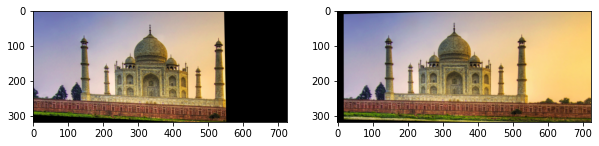

In [78]:
img1_2,img2_2,img_2 = get_imgs('2_1.png','2_2.png')
size = (img1_2.shape[1],img1_2.shape[0])
rectified_img1,rectified_img2 = rectify(img1_2,img2_2,pts1_2,pts2_2,F_2,size)

display_plots(rectified_img1,rectified_img2)

In [83]:
img1_3,img2_3,img_3 = get_imgs('3_1.jpg','3_2.jpg')
F_3,pts1_3,pts2_3 = find_fundamental(img1_3,img2_3,threshold=0.8)

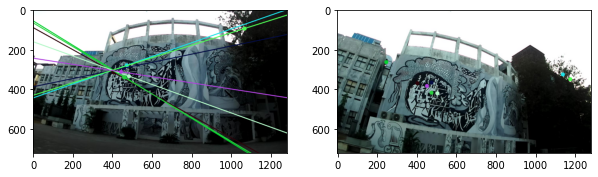

In [84]:
lines3_2,img3,img4 = lines(img1_3,img2_3,pts1_3,pts2_3,F_3)

display_plots(img3,img4)

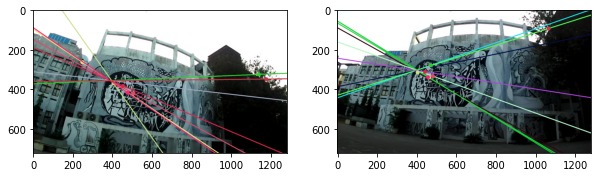

In [85]:
lines3_1,img5,img6 = lines(img2_3,img1_3,pts2_3,pts1_3,F_3.T)

display_plots(img5,img3)

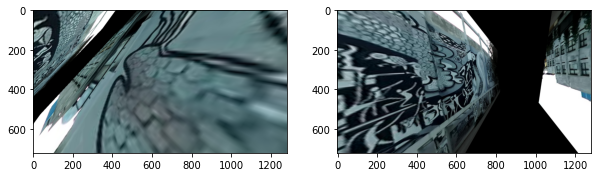

In [86]:
img1_3,img2_3,img_3 = get_imgs('3_1.jpg','3_2.jpg')
size = (img1_3.shape[1],img1_3.shape[0])
rectified_img1,rectified_img2 = rectify(img1_3,img2_3,pts1_3,pts2_3,F_3,size)

display_plots(rectified_img1,rectified_img2)